## Library imports

The [RDKit library](https://github.com/rdkit/rdkit) provides a convenient, robust, and well tested interface for manipulating and drawing molecules.

In [1]:
from rdkit.Chem import MolFromMolFile
from rdkit import RDLogger                                                                                                                                                               
from pathlib import Path
from collections import deque
from pprint import pprint
from utils import *
RDLogger.DisableLog('rdApp.*')

MOLFILEPATH = "../test/testfiles"

# Serialization

The serialization should result in a string representation of the molecule. The string representation should allow for the automatized reconstruction of the molecule's topology (i.e., the molecular graph). Additionally, ideally the representation should be intuitive enough for a human to be able to reconstruct the molecular graph.

Our string representation consists of the sum formula, followed by a sequence of tuples. Each tuple represents the indices of two connected atoms (i.e., `(index X, index Y)`). For example, the string representation of ethanol is `C2H6O:(0,6)(1,6)(2,6)(3,7)(4,7)(5,8)(6,7)(7,8)`.
In order to be able to reconstruct the molecule based on this representation, we organize the tuples such that increasing indices pertain to atoms with increasing atomic number. This means that we can infer an atom's atomic number from the sum formula. Let's illustrate this with the ethanol example above. The sum formula of ethanol indicates that the molecule consists of six `H`s, two `C`s and one `O`. Since increasing indices pertain to atoms with increasing atomic number, we can infer that the indices 0 to 6 pertain to `H`s, indices 7 and 8 pertain to `C`s, and finally, index 8 pertains to an `O`.

This string representation cannot be derived from the original molecule, since increasing atom indices do not pertain to increasing atomic numbers. Therefore, we sort the molecule's atoms by atomic number. However, in a typical molecule there are multiple atoms with the same atomic number. Consider for example the five `C` atoms below (atomic number 6). To further differentiate these `C` atoms, we rank them [lexicographically](https://en.wikipedia.org/wiki/Lexicographic_order) by the atomic numbers of their neighbours. More specifically, for each atom `A` we construct a list of the atomic numbers of `A`'s neighbors, like so:

| index | list of neighboring atomic number |
|-------|-----------------------------------|
| 4     | [7, 6, 6] |
| 5     | [7, 7] |
| 6     | [7, 7, 6] |
| 7     | [7, 7, 7] |
| 8     | [8, 7, 6] |

Note that each list of neighboring atomic numbers is sorted in decreasing order. This ensures that the lexicographic sorting, ranks atoms with identical atomic numbers by their "largest" neighbors (in terms of atomic numbers).

original
╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               6 │           0 │ [(1, 6, 0), (5, 6, 0), (11, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               6 │           0 │ [(0, 6, 0), (2, 6, 0), (12, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               6 │           0 │ [(1, 6, 0), (3, 6, 0), (13, 1, 0)]            │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               6 │           0 │ [(2, 6, 0), (4, 6, 0), (6, 6, 0)]             │
├─────────┼─────────────────┼─────────────┼────────────────────────────

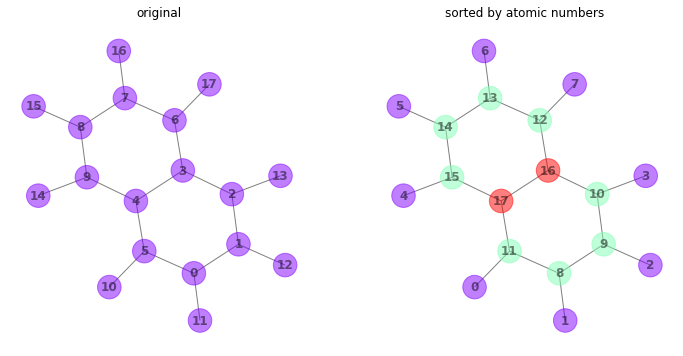

In [2]:
molecule = "naphthalene"
m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
m_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m)
print_molecule(m, "original")
print_molecule(m_sorted_by_atomic_numbers, "sorted by atomic number")
draw_molecules([m, m_sorted_by_atomic_numbers], ["original", "sorted by atomic numbers"], highlight="partition")


Subsequently, the molecule is partitioned such that the following is true for the atoms that share a partition: elaborate

Note that the recursive partitioning almost shatters the molecule. That is, many partitions contain only a few molecules. If our serialization would completely shatter the molecule, the serialization itself would serve as canonicalization, since the goal of canonicalization is to uniquely identify each atom. 


╒═════════╤═════════════════╤═════════════╤═══════════════════════════════════════════════╕
│   index │   atomic number │   partition │ neighbors (index, atomic number, partition)   │
╞═════════╪═════════════════╪═════════════╪═══════════════════════════════════════════════╡
│       0 │               1 │           0 │ [(8, 6, 2)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       1 │               1 │           0 │ [(9, 6, 2)]                                   │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       2 │               1 │           0 │ [(11, 6, 2)]                                  │
├─────────┼─────────────────┼─────────────┼───────────────────────────────────────────────┤
│       3 │               1 │           0 │ [(10, 6, 2)]                                  │
├─────────┼─────────────────┼─────────────┼────────────────────────────────────

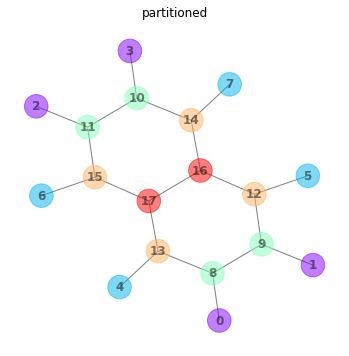

In [3]:
m_partitioned = partition_molecule_recursively(m_sorted_by_atomic_numbers, show_steps=False)
print_molecule(m_partitioned)
draw_molecules([m_partitioned], ["partitioned"], highlight="partition")

root: 0
(0, 8)
(8, 9)
(8, 13)
(9, 12)
(9, 1)
(13, 4)
(12, 5)
root: 1
root: 2
(2, 11)
(11, 10)
(11, 15)
(10, 14)
(10, 3)
(15, 6)
(14, 7)
root: 3
root: 4
root: 5
root: 6
root: 7
root: 8
root: 9
root: 10
root: 11
root: 12
root: 13
root: 14
root: 15
root: 16
root: 17
[(0, 8), (8, 9), (8, 13), (9, 12), (9, 1), (13, 4), (12, 5), (2, 11), (11, 10), (11, 15), (10, 14), (10, 3), (15, 6), (14, 7)]


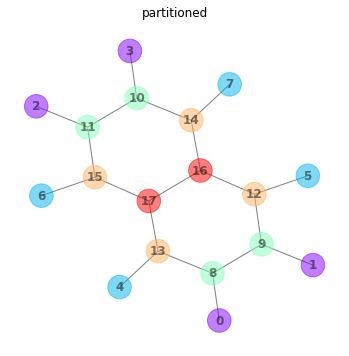

In [4]:
molecule = "naphthalene"
m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
m_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m)
m_partitioned = partition_molecule_recursively(m_sorted_by_atomic_numbers, show_steps=False)


for a in m_partitioned.GetAtoms():
    a.SetBoolProp("explored", False)

tuples = []
for a in m_partitioned.GetAtoms():
# def bfs_molecule(root_atom):
    print("root:", a.GetIdx())
    root_atom = a
    root_atom.SetBoolProp("explored", True)
    atom_queue = deque([root_atom])
    while atom_queue:
        atom = atom_queue.popleft()
        for n in atom.GetNeighbors():
            if n.GetBoolProp("explored"):
                continue
            n_neighbors = n.GetNeighbors()
            if len({nn.GetIntProp("partition") for nn in n_neighbors}) != len(n_neighbors):
                continue
            bond = (atom.GetIdx(), n.GetIdx())
            print(bond)
            tuples.append(bond)
            n.SetBoolProp("explored", True)
            atom_queue.append(n)

print(tuples)
draw_molecules([m_partitioned], ["partitioned"], highlight="partition")



Atoms must not necessarily be in unique partitions.
However, there musn't be duplicate partitions in any atom's neighbors.
If there aren't duplicates in any atom's neighbors, the molecular graph can be traversed deterministically by branching in a principled way.

Finally, we write the string representation for the molecule.

In [5]:
string = write_string_representation(m_partitioned)
print(string)

C10H8:(0, 8)(1, 9)(2, 11)(3, 10)(4, 13)(5, 12)(6, 15)(7, 14)(8, 9)(8, 13)(9, 12)(10, 11)(10, 14)(11, 15)(12, 16)(13, 17)(14, 16)(15, 17)(16, 17)


# Invariance Test
In order to be useful for the identification of a molecule, the serialization must be invariant. That is, irrespective of a molecule's initial atom labels, the serialization should always result in the same string representation. Below we set up a simple test of invariance. 

In [6]:
testfiles = list(Path(MOLFILEPATH).glob("*/*.mol"))
canonicalization_steps = [sort_molecule_by_atomic_numbers, partition_molecule_recursively]
failed_molecules = []
n_failed_molecules = 0
n_molecules = 0

for molfile in testfiles:
    m = load_molfile(molfile)
    if not m: continue
    print(f"\nTesting {str(molfile)} for invariance...\n")
    if not test_invariance(m, canonicalization_steps):
        n_failed_molecules += 1
        failed_molecules.append(molfile.stem)
    n_molecules += 1
        
print(f"\n{n_failed_molecules}/{n_molecules} failures:")
pprint(failed_molecules)


Testing ../test/testfiles/2-8-dimethyldecane/2-8-dimethyldecane.mol for invariance...

C12H26:(0, 26)(1, 26)(2, 26)(3, 27)(4, 27)(5, 27)(6, 28)(7, 28)(8, 28)(9, 29)(10, 29)(11, 29)(12, 30)(13, 30)(14, 31)(15, 31)(16, 32)(17, 32)(18, 33)(19, 33)(20, 34)(21, 34)(22, 35)(23, 35)(24, 36)(25, 37)(26, 33)(27, 36)(28, 36)(29, 37)(30, 31)(30, 32)(31, 34)(32, 35)(33, 37)(34, 36)(35, 37)
doesn't match
C12H26:(0, 26)(1, 26)(2, 26)(3, 28)(4, 28)(5, 27)(6, 27)(7, 27)(8, 28)(9, 29)(10, 29)(11, 29)(12, 30)(13, 30)(14, 31)(15, 31)(16, 32)(17, 32)(18, 33)(19, 33)(20, 34)(21, 34)(22, 35)(23, 35)(24, 36)(25, 37)(26, 33)(27, 36)(28, 36)(29, 37)(30, 31)(30, 32)(31, 34)(32, 35)(33, 37)(34, 36)(35, 37).

Testing ../test/testfiles/2-aminopyridine/2-aminopyridine.mol for invariance...

C5H6N2:(0, 6)(1, 7)(2, 8)(3, 9)(4, 11)(5, 11)(6, 7)(6, 8)(7, 9)(8, 10)(9, 12)(10, 11)(10, 12)
matches
C5H6N2:(0, 6)(1, 7)(2, 8)(3, 9)(4, 11)(5, 11)(6, 7)(6, 8)(7, 9)(8, 10)(9, 12)(10, 11)(10, 12).

Testing ../test/testfiles/ace

/workspaces/nInChI_prototype/notebooks/utils.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(n_molecules * 6, 6))


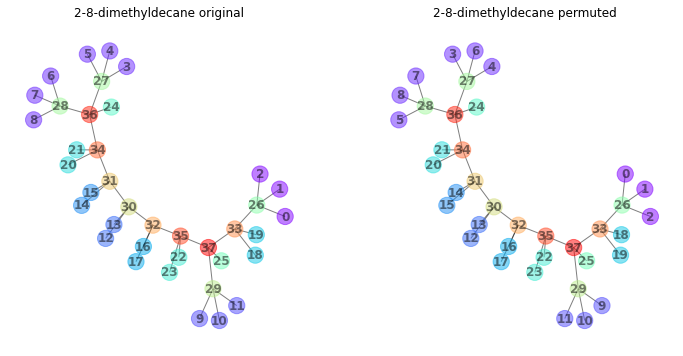

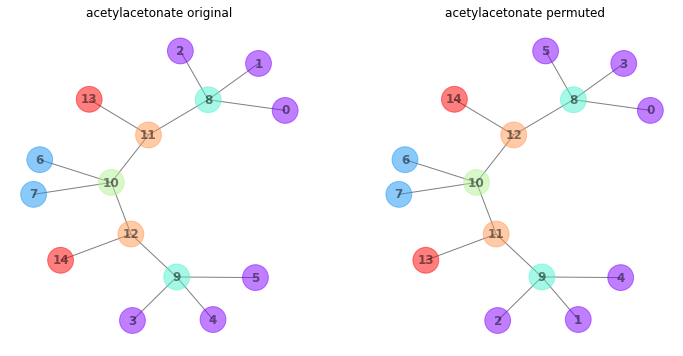

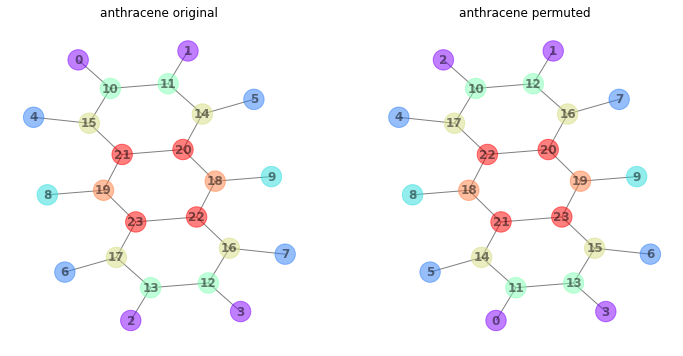

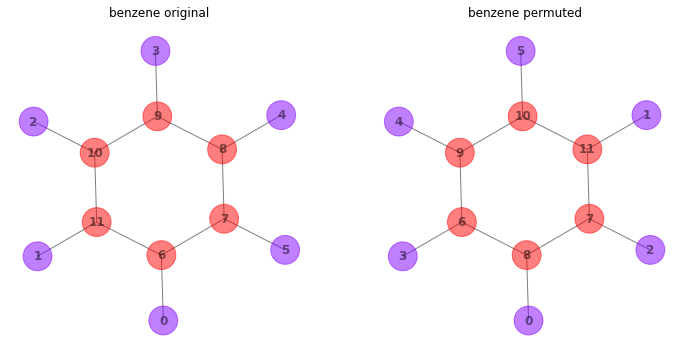

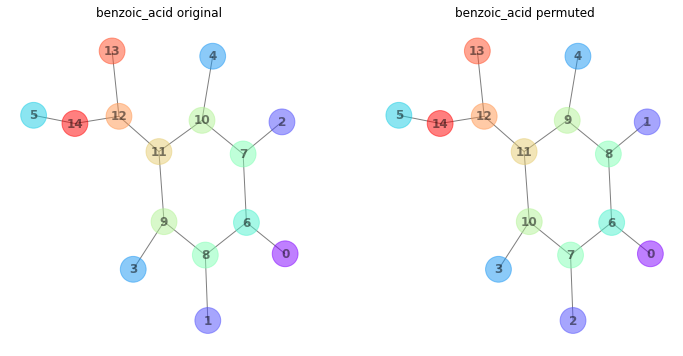

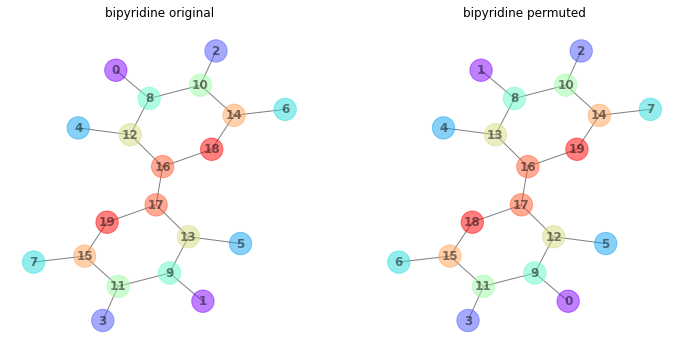

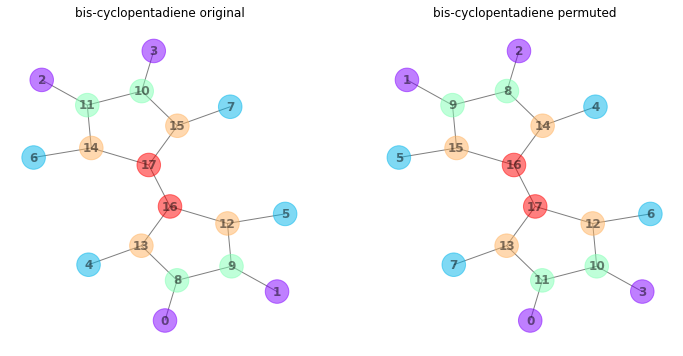

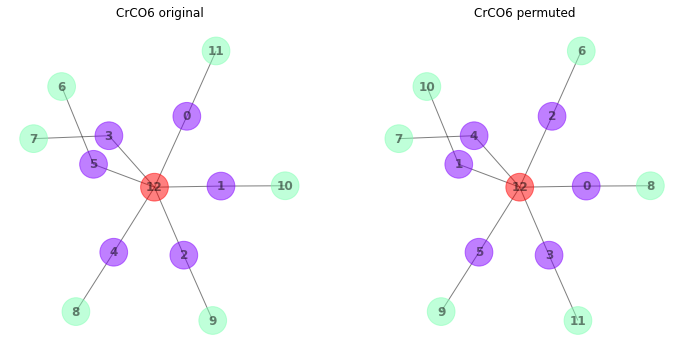

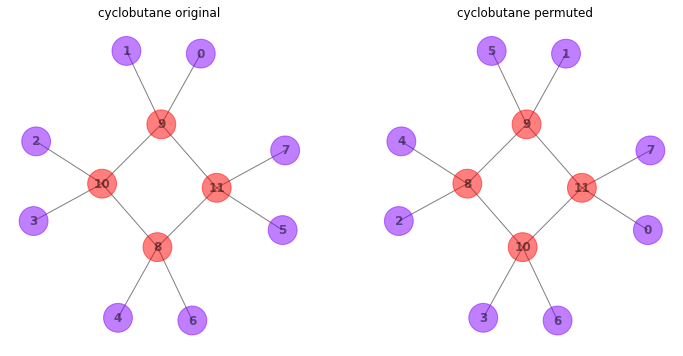

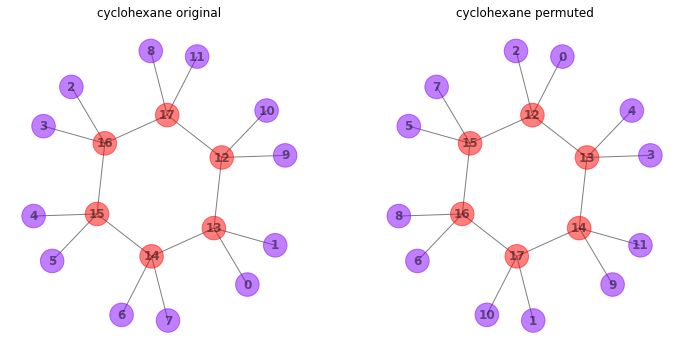

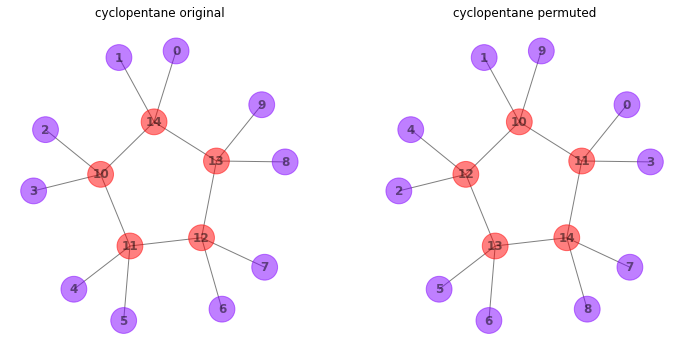

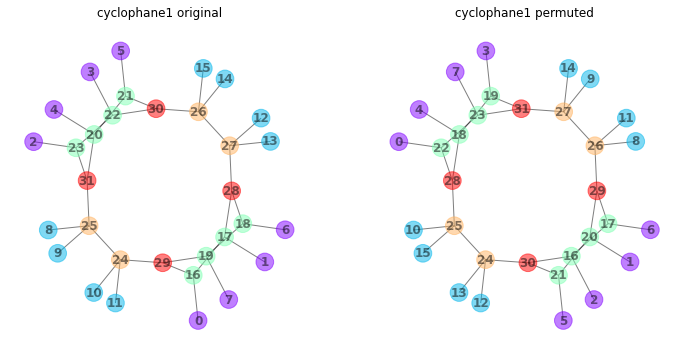

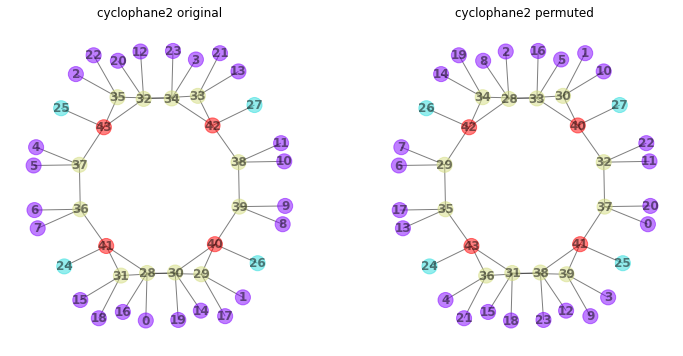

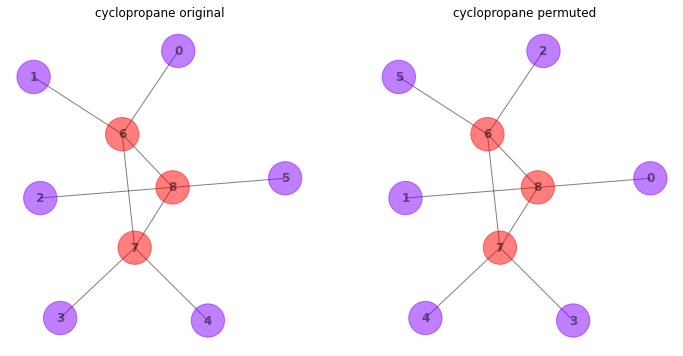

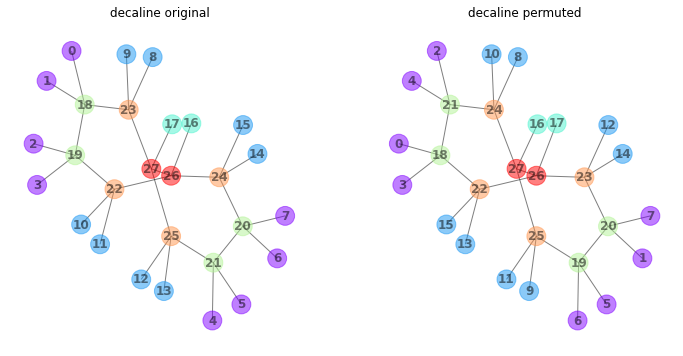

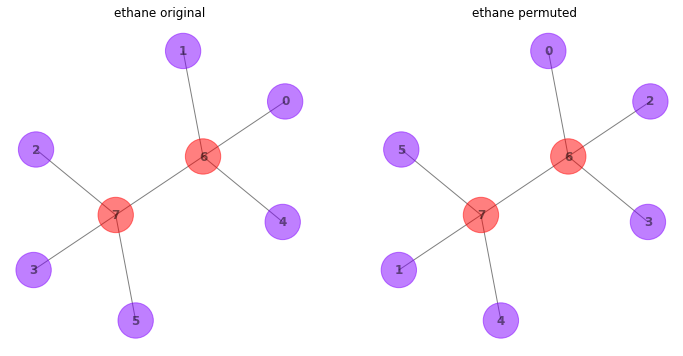

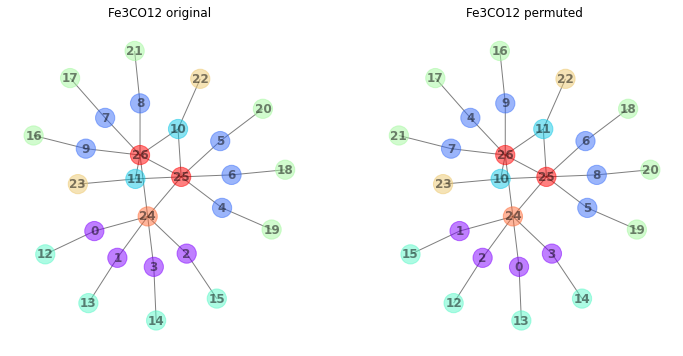

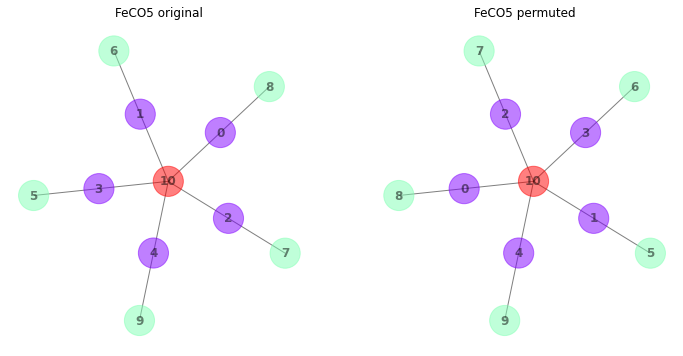

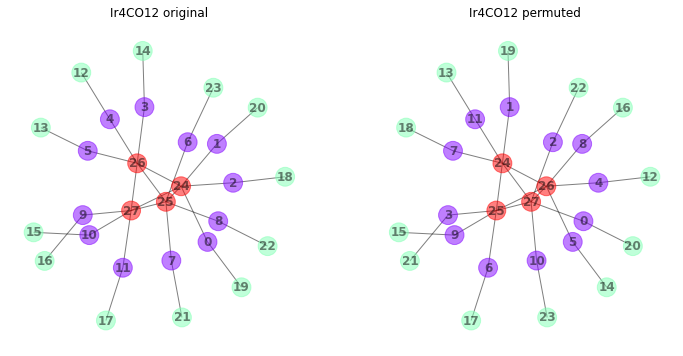

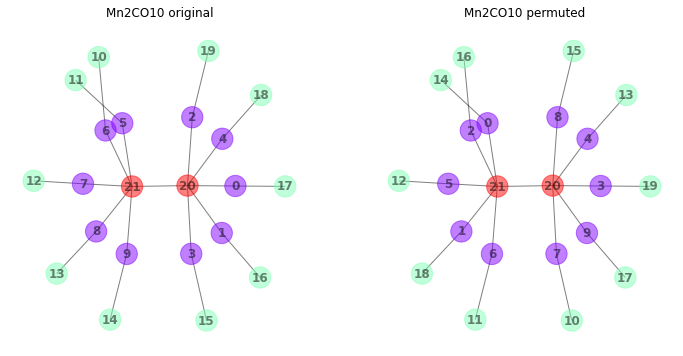

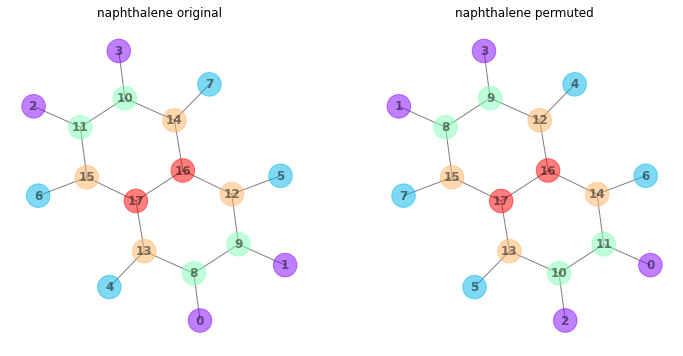

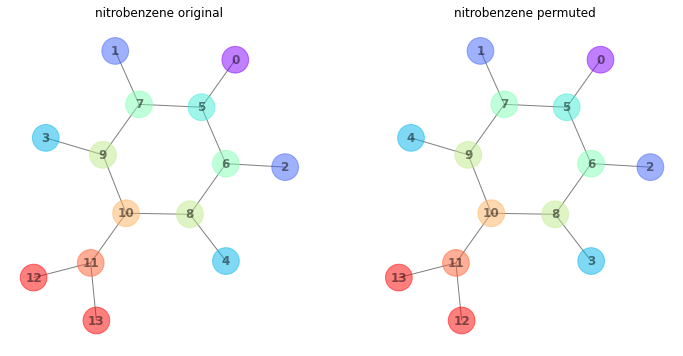

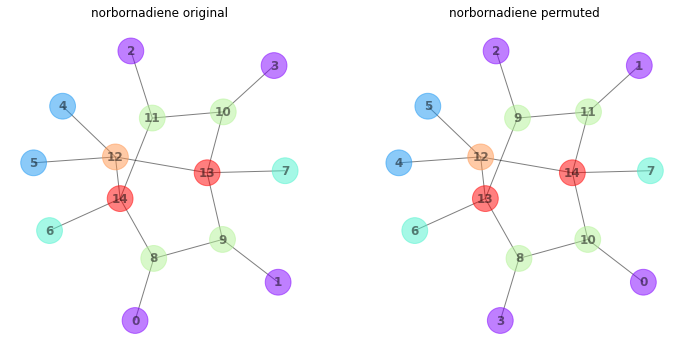

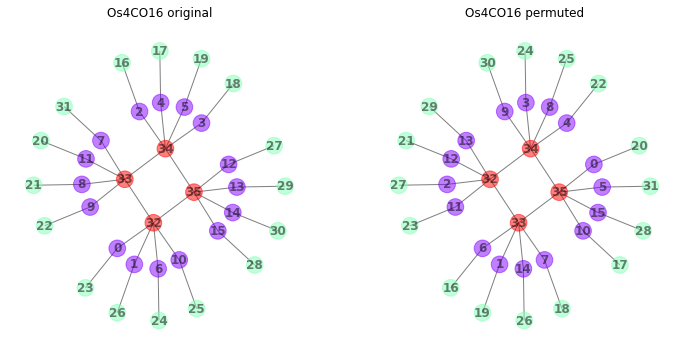

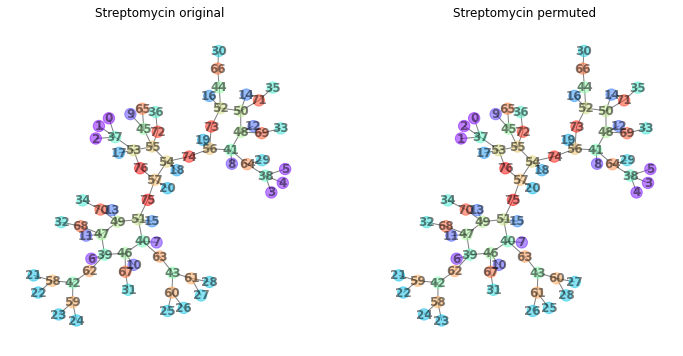

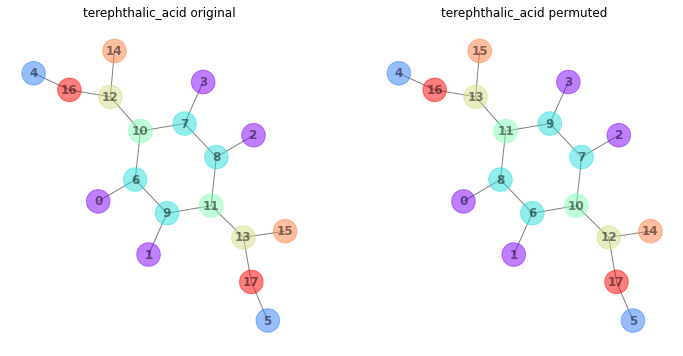

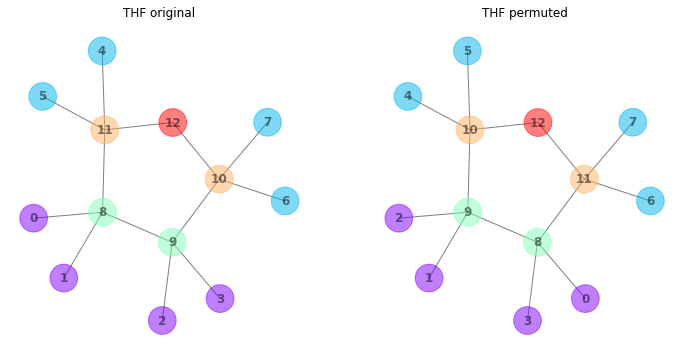

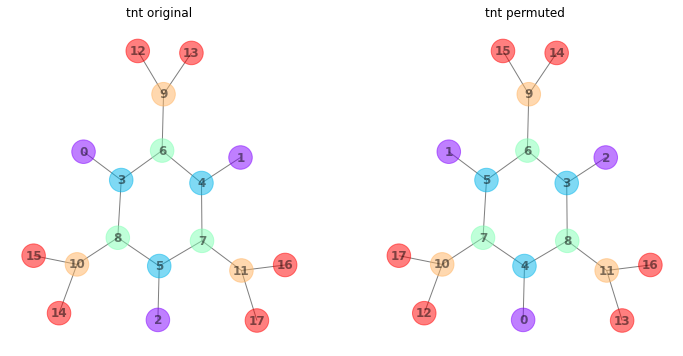

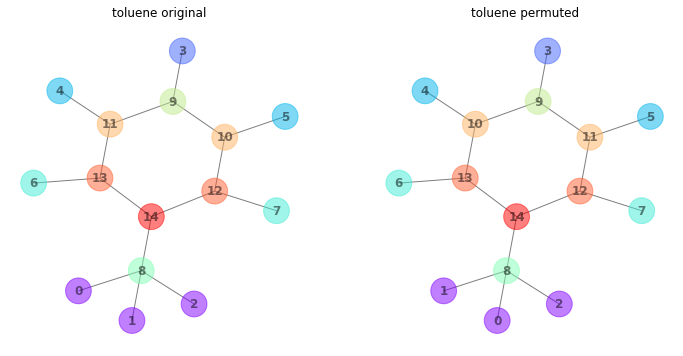

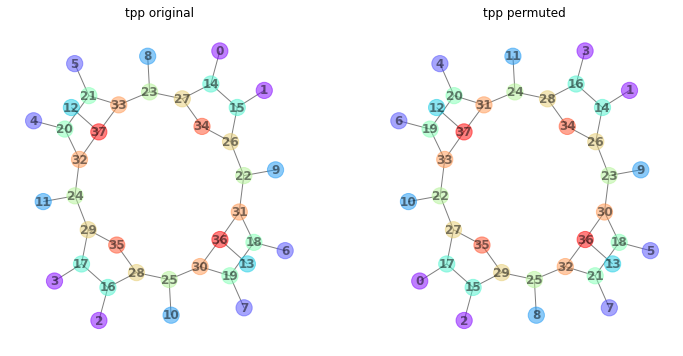

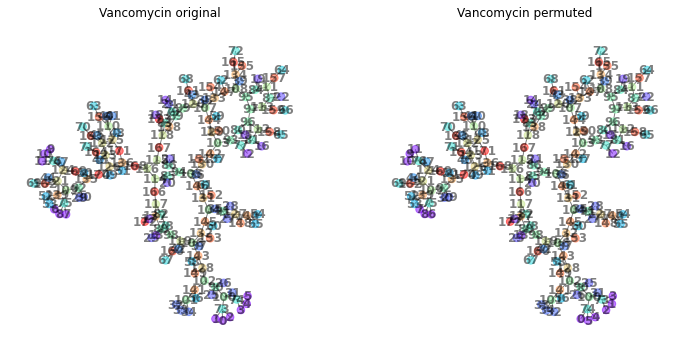

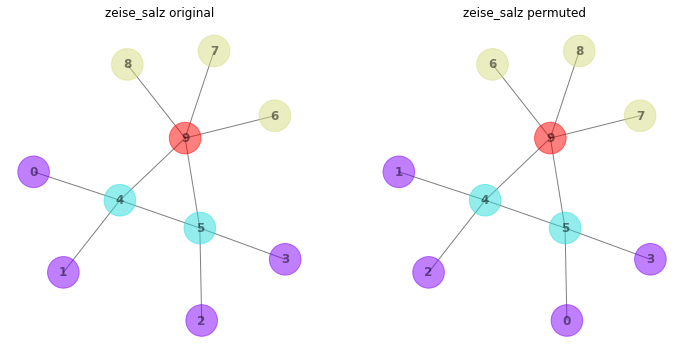

In [7]:
for molecule in failed_molecules:

  m = MolFromMolFile(f"{MOLFILEPATH}/{molecule}/{molecule}.mol", removeHs=False)
  m_permu = permute_molecule(m)

  m_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m)
  m_permu_sorted_by_atomic_numbers = sort_molecule_by_atomic_numbers(m_permu)

  m_partitioned = partition_molecule_recursively(m_sorted_by_atomic_numbers, show_steps=False)
  m_permu_partitioned = partition_molecule_recursively(m_permu_sorted_by_atomic_numbers, show_steps=False)

  # print_molecule(m_partitioned, "original")
  # print_molecule(m_permu_partitioned, "permuted")

  string_m = write_string_representation(m_partitioned)
  string_m_permu = write_string_representation(m_permu_partitioned)

  draw_molecules([m_partitioned, m_permu_partitioned],
                 [f"{molecule} original", f"{molecule} permuted"],
                 highlight="partition")
